In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Species

In [3]:
df_species = pd.read_parquet('../processed_data/species_coverage.parquet')

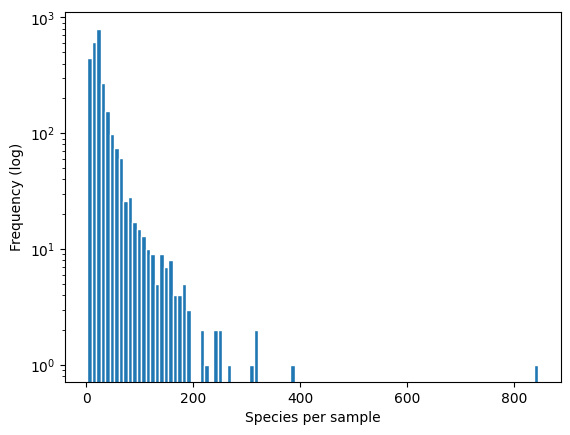

In [4]:
# Species per Sample
count_species_sample = (df_species > 0).sum(1).sort_values(ascending=False)
plt.hist(count_species_sample.values, edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Species per sample')
plt.yscale('log')
plt.show()

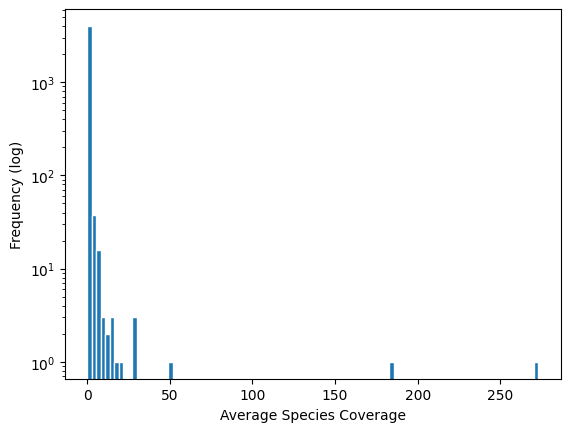

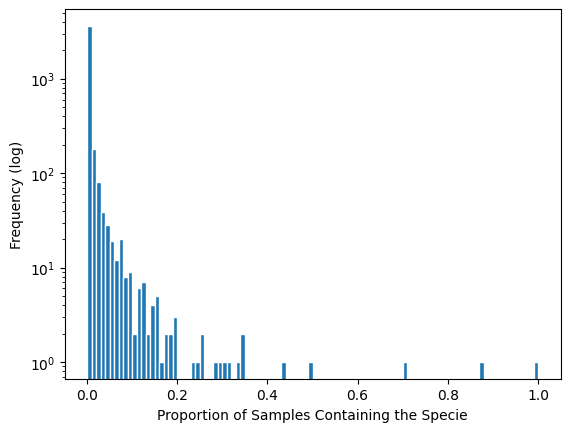

In [5]:
# Average Species Coverage
sum_species_coverage = df_species.sum(0).sort_values(ascending=False)
plt.hist(sum_species_coverage.values/df_species.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Average Species Coverage')
plt.yscale('log')
plt.show()

# Average Species Count
count_species = (df_species > 0).sum(0).sort_values(ascending=False)
plt.hist(count_species.values / df_species.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Proportion of Samples Containing the Specie')
plt.yscale('log')
plt.show()

In [6]:
count_threshold = 100

print(f'# Species that appear in less than {count_threshold} samples: {int((count_species < count_threshold).sum())}')

# Species that appear in less than 100 samples: 3916


# Genes

In [7]:
df_genes = pd.read_parquet('../processed_data/gene_coverage.parquet')
df_genes = df_genes.set_index("Sample")

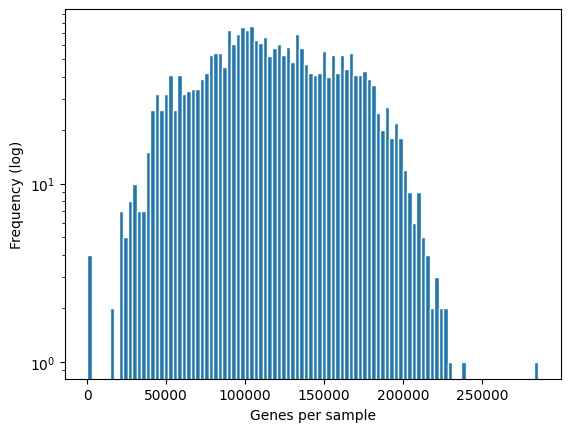

In [8]:
# Genes per Sample
count_genes_sample = (df_genes > 0).sum(1).sort_values(ascending=False)
plt.hist(count_genes_sample.values, edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Genes per sample')
plt.yscale('log')
plt.show()

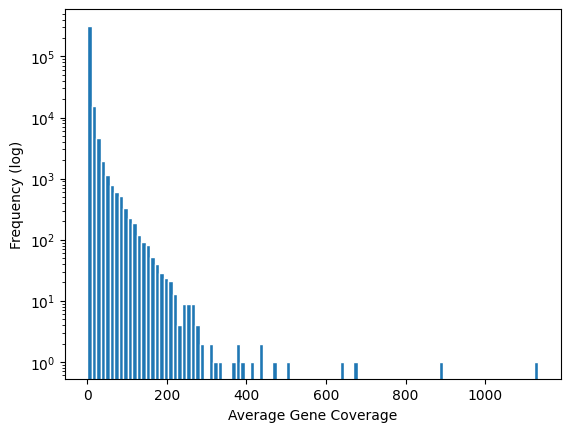

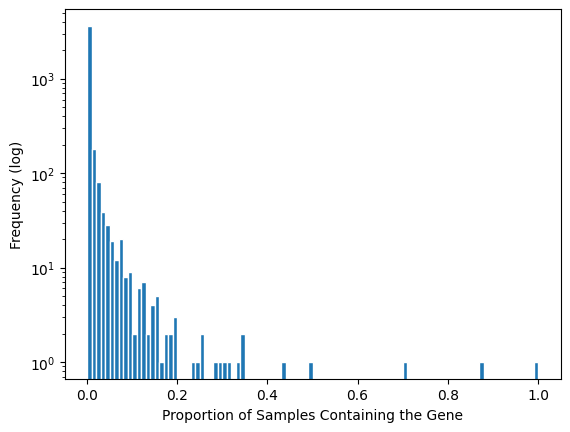

In [9]:
# Average Gene Coverage
sum_species_coverage = df_genes.sum(0).sort_values(ascending=False)
plt.hist(sum_species_coverage.values/df_genes.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Average Gene Coverage')
plt.yscale('log')
plt.show()

# Average Gene Count
count_genes = (df_genes > 0).sum(0).sort_values(ascending=False)
plt.hist(count_species.values / df_genes.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Proportion of Samples Containing the Gene')
plt.yscale('log')
plt.show()

In [10]:
count_threshold = 100

print(f'# Genes that appear in less than {count_threshold} samples: {int((count_genes < count_threshold).sum())}')

# Genes that appear in less than 100 samples: 64639


# Useless Data

In [11]:
print(f'{(count_genes==0).sum()} genes never show up')
print(f'{(count_species==0).sum()} species never show up')

print(f'{(count_genes==count_genes.shape[0]).sum()} genes always show up')
print(f'{(count_species==count_species.shape[0]).sum()} species always show up')

6328 genes never show up
0 species never show up
0 genes always show up
0 species always show up


# Sparsity

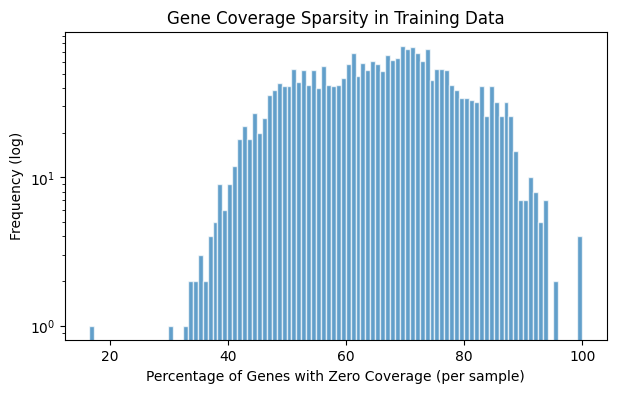

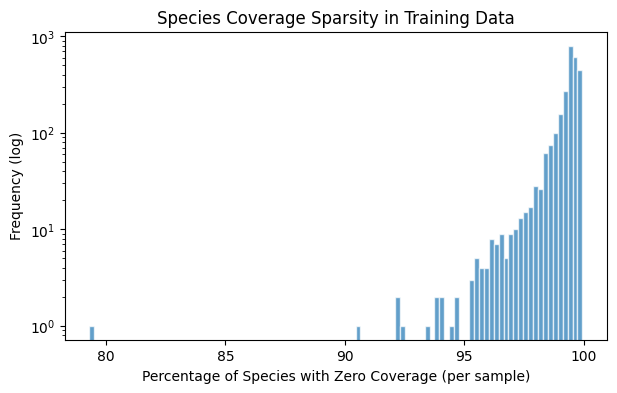

In [12]:
# Gene Sparsity per Sample
gene_sparsity = (df_genes == 0).sum(axis=1) / df_genes.shape[1] * 100

plt.figure(figsize=(7, 4))
plt.hist(gene_sparsity.values, bins=100, edgecolor='white', alpha=0.7)
plt.xlabel("Percentage of Genes with Zero Coverage (per sample)")
plt.ylabel("Frequency (log)")
plt.yscale("log")  # Log scale for better visibility
plt.title("Gene Coverage Sparsity in Training Data")
plt.show()

# Species Sparsity per Sample
species_sparsity = (df_species == 0).sum(axis=1) / df_species.shape[1] * 100  # Percentage of zero species per sample

plt.figure(figsize=(7, 4))
plt.hist(species_sparsity.values, bins=100, edgecolor='white', alpha=0.7)
plt.xlabel("Percentage of Species with Zero Coverage (per sample)")
plt.ylabel("Frequency (log)")
plt.yscale("log")  # Log scale for better visibility
plt.title("Species Coverage Sparsity in Training Data")
plt.show()

## Core Genes

$$
M_{ij} = \frac{\sum_k S_{ki} G_{kj}}{\min(N_i, N_j)}
$$

where:

$$
S \in \{0,1\}^{n_{\text{samples}} \times n_{\text{species}_f}},
$$
$$
G \in \{0,1\}^{n_{\text{samples}} \times n_{\text{genes}_f}}
$$

$$
N_i = \sum_k S_{ki}, \quad N_j = \sum_k G_{kj}
$$


In [13]:
# We'll use a co-occurrence matrix to determine the core genes. 
# For it to be manageable we must remove non statistically significant species and genes!

###############################################################################
# 0) Parameters
###############################################################################
threshold = 200  # minimum number of samples in which a gene/species must appear

###############################################################################
# 1) Match sample indices
###############################################################################
common_samples = np.intersect1d(df_genes.index.values, df_species.index.values)
df_genes_matched = df_genes.loc[common_samples]
df_species_matched = df_species.loc[common_samples]

###############################################################################
# 2) Apply the per-column presence filter (≥ threshold)
#    - We want to keep only those genes/species that appear in at least
#      'threshold' samples.
###############################################################################

# Convert to NumPy arrays
genes_array = df_genes_matched.to_numpy()     # shape (n_samples, n_genes)
species_array = df_species_matched.to_numpy() # shape (n_samples, n_species)

# Boolean arrays where True = present (> 0), False = absent (== 0)
genes_presence = (genes_array > 0)
species_presence = (species_array > 0)

# Count how many samples have each gene (column) present
gene_nonzero_counts = np.sum(genes_presence, axis=0)  # shape (n_genes,)
# Build mask for columns that appear in >= threshold samples
gene_mask = gene_nonzero_counts >= threshold

# Count how many samples have each species (column) present
species_nonzero_counts = np.sum(species_presence, axis=0)  # shape (n_species,)
# Build mask for columns that appear in >= threshold samples
species_mask = species_nonzero_counts >= threshold

# Filter arrays to keep only those columns
genes_filtered = genes_array[:, gene_mask]       # shape (n_samples, n_genes_f)
species_filtered = species_array[:, species_mask] # shape (n_samples, n_species_f)

# Also build the new presence arrays so we can do co-occurrence
genes_presence_f = genes_presence[:, gene_mask]       # shape (n_samples, n_genes_f)
species_presence_f = species_presence[:, species_mask] # shape (n_samples, n_species_f)

###############################################################################
# 3) Compute the co-occurrence matrix
#    We want a matrix of shape (n_species_f, n_genes_f) with entries:
#       #samples where species_i & gene_j both present
#       -------------------------------------------------
#       max(#samples species_i present, #samples gene_j present)
###############################################################################

# Count co-occurrences using matrix multiplication:
#   presence_species_f: shape (n_samples, n_species_f) --> but we need (n_samples, n_species_f) * (n_samples, n_genes_f)?
#   Actually we want (n_species_f, n_samples) @ (n_samples, n_genes_f) => (n_species_f, n_genes_f)
#   So we transpose species_presence_f to shape (n_species_f, n_samples).

# However, np.dot(...) needs numeric (int/float). We can cast bool->int.
species_int = species_presence_f.astype(int).T   # shape (n_species_f, n_samples)
genes_int = genes_presence_f.astype(int)         # shape (n_samples, n_genes_f)

# co_occurrence_counts[i, j] = sum over samples of (species_i_present * gene_j_present)
co_occurrence_counts = np.dot(species_int, genes_int)  # shape (n_species_f, n_genes_f)

# Next, we need the denominators:
#   denom(i, j) = max(#samples species_i present, #samples gene_j present)
# We already have species_nonzero_counts and gene_nonzero_counts, but let's
# get them for the *filtered* sets:
species_pres_counts_f = np.sum(species_presence_f, axis=0)  # shape (n_species_f,)
gene_pres_counts_f = np.sum(genes_presence_f, axis=0)       # shape (n_genes_f,)

# For each (i, j), denominator = max(species_pres_counts_f[i], gene_pres_counts_f[j]).
# We can do that in a fully vectorized way with np.maximum.outer:
denominator_matrix = np.minimum.outer(species_pres_counts_f, gene_pres_counts_f)  
# shape (n_species_f, n_genes_f)

# Finally, compute the ratio. Convert to float to avoid integer division:
co_occurrence_matrix = co_occurrence_counts / denominator_matrix

###############################################################################
# 4) Wrap up results
#    co_occurrence_matrix has shape (n_species_f, n_genes_f).
#    Optionally, you can build a DataFrame with the filtered names:
###############################################################################
filtered_species_names = df_species_matched.columns[species_mask]
filtered_gene_names = df_genes_matched.columns[gene_mask]

df_co_occurrence = pd.DataFrame(
    co_occurrence_matrix,
    index=filtered_species_names,
    columns=filtered_gene_names
)

print("Co-occurrence matrix shape:", df_co_occurrence.shape)

Co-occurrence matrix shape: (78, 255201)


In [14]:
df_co_occurrence.T

,Bifidobacterium longum,Bifidobacterium infantis,Bifidobacterium breve,Bifidobacterium bifidum,Bacteroides fragilis,Phocaeicola vulgatus,Parabacteroides distasonis,Faecalibacterium longum,Faecalibacterium sp900758465,Flavonifractor plautii,...,Faecalibacterium duncaniae,Lactobacillus sp944327175,Lactobacillus delbrueckii,Streptococcus mutans,Blautia coccoides,Pseudomonas_E putida,Megasphaera elsdenii,Agathobacter faecis,Bifidobacterium dentium,Anaeroglobus micronuciformis
MGYG000040295_1_1076,0.957884,1.0,0.626836,0.630513,0.513189,0.414729,0.228442,0.430052,0.511848,0.293269,...,0.096059,0.011494,0.018587,0.014981,0.059561,0.000000,0.099502,0.462882,0.375000,0.385366
MGYG000235258_187_1,0.990361,1.0,0.321687,0.251807,0.352518,0.418605,0.611195,0.383420,0.336493,0.549398,...,0.773399,0.915709,0.903346,0.906367,0.827586,0.920949,0.721393,0.493450,0.375000,0.317073
MGYG000287854_166_1,0.961342,1.0,0.688412,0.746126,0.719424,0.651163,0.402421,0.805699,0.786730,0.465144,...,0.322660,0.019157,0.040892,0.037453,0.128527,0.000000,0.139303,0.882096,0.516667,0.497561
MGYG000081795_71_1,0.983412,1.0,0.386256,0.286730,0.223022,0.310427,0.270142,0.256477,0.199052,0.338863,...,0.145320,0.011494,0.014870,0.022472,0.068966,0.000000,0.019900,0.353712,0.262500,0.170732
MGYG000251915_8_1,0.959677,1.0,0.608871,0.508065,0.472422,0.472868,0.307110,0.577720,0.592417,0.360215,...,0.211823,0.015326,0.033457,0.029963,0.075235,0.000000,0.119403,0.580786,0.591667,0.492683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGYG000032708_99_5,0.967593,1.0,0.350926,0.339690,0.405276,0.451550,0.682300,0.458549,0.478673,0.591346,...,0.830049,0.980843,0.973978,0.977528,0.887147,1.000000,0.860697,0.497817,0.458333,0.351220
MGYG000174374_194_5,0.983087,1.0,0.533827,0.474374,0.503597,0.459302,0.285930,0.378238,0.388626,0.322115,...,0.160099,0.042146,0.048327,0.059925,0.119122,0.031621,0.084577,0.423581,0.458333,0.404878
MGYG000063533_28_7,0.967611,1.0,0.619433,0.473684,0.419664,0.403101,0.220877,0.487047,0.545024,0.283401,...,0.103448,0.015326,0.014870,0.011236,0.043887,0.000000,0.069652,0.353712,0.250000,0.321951
MGYG000178890_63_8,0.894630,1.0,0.679828,0.718713,0.623501,0.687984,0.429652,0.715026,0.696682,0.459135,...,0.278325,0.076628,0.085502,0.082397,0.169279,0.051383,0.159204,0.689956,0.608333,0.590244


In [17]:
# Sanity check. Bifidobacterium infantis should have all genes always
df_co_occurrence.T['Bifidobacterium infantis'].sum() == df_co_occurrence.shape[1]

np.True_

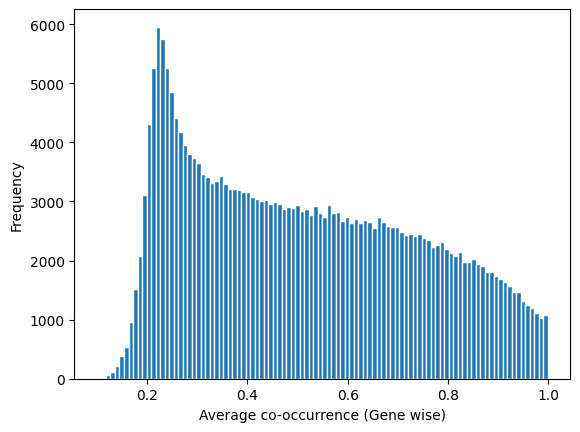

In [26]:
# Co-occurrence sum per gene
sum_co_occ_genes = df_co_occurrence.T.sum(1)/df_co_occurrence.shape[0]
plt.hist(sum_co_occ_genes.values, edgecolor='white', bins=100)
plt.ylabel('Frequency')
plt.xlabel('Average co-occurrence (Gene wise)')
#plt.yscale('log')
plt.show()

# Samples

## Jaccard

In [20]:
# First plot I sent to Shaul
df_genes

,MGYG000017480_144_1,MGYG000005240.fa_11_12,MGYG000040295_1_1076,MGYG000161889_281_2,MGYG000081795_169_4,MGYG000235258_187_1,MGYG000040295_1_1078,MGYG000287854_166_1,MGYG000081795_71_1,MGYG000178501_217_1,...,MGYG000117193_352_1,MGYG000032708_99_5,MGYG000272348_88_1,MGYG000040295_1_1073,MGYG000174374_194_5,MGYG000005240.fa_11_10,MGYG000063533_28_7,MGYG000178890_63_8,MGYG000005240.fa_11_11,MGYG000272348_88_5
Sample,,,,,,,,,,,,,,,,,,,,,
DRR003635,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,1.651210,0.0,...,0.00000,1.264100,0.0,0.0,0.482759,0.0,0.000000,0.000000,0.0,1.865920
DRR003644,0.0,0.00000,51.841999,0.0,0.000000,2.69893,0.0,29.908800,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.201288,2.535090,0.0,0.000000
DRR014176,0.0,0.00000,0.000000,0.0,0.639785,13.89050,0.0,0.000000,0.000000,0.0,...,0.00000,0.900001,0.0,0.0,0.000000,0.0,0.000000,20.210501,0.0,0.000000
DRR042312,0.0,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.495853,0.000000,0.0,...,0.00000,0.704225,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
DRR070915,0.0,0.00000,0.433527,0.0,0.682796,8.40952,0.0,0.410172,0.993378,0.0,...,0.00000,0.000000,0.0,0.0,0.555556,0.0,36.681198,1.437980,0.0,4.729980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9865754,0.0,0.00000,116.745003,0.0,0.000000,0.00000,0.0,40.709801,0.000000,0.0,...,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.438596,0.0,0.000000
SRR9879728,0.0,0.00000,0.000000,0.0,0.000000,3.36022,0.0,0.069652,0.278146,0.0,...,1.01026,0.887324,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.437616
SRR9879766,0.0,0.00000,297.359009,0.0,0.000000,0.00000,0.0,31.579300,0.000000,0.0,...,0.00000,0.876923,0.0,0.0,6.333330,0.0,0.000000,0.654971,0.0,0.000000


In [ ]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to compute cosine similarity in batches
def compute_cosine_similarity(df):
    n_samples = df.shape[0]
    
    # Compute all pairwise cosine distances (faster than loops!)
    similarities = 1 - dist.pdist(df, metric="cosine")
    
    # Convert condensed matrix to square form
    similarity_matrix = dist.squareform(similarities)
    
    return similarity_matrix

# Wrapping pdist in tqdm to show progress
def compute_cosine_similarity_with_progress(df, batch_size=5):
    n_samples = df.shape[0]
    similarity_matrix = np.zeros((n_samples, n_samples))

    # Process in batches for better performance
    for i in tqdm(range(0, n_samples, batch_size), desc="Computing Cosine Similarity", unit="batch"):
        end = min(i + batch_size, n_samples)
        similarities = 1 - dist.cdist(df.iloc[i:end, :], df, metric="cosine")
        similarity_matrix[i:end, :] = similarities
    
    return similarity_matrix

# Compute similarity matrices with progress tracking
gene_similarity = compute_cosine_similarity_with_progress(df_genes)
species_similarity = compute_cosine_similarity_with_progress(df_species)

# Flatten for scatter plot (pairwise sample similarity)
gene_similarity_flat = gene_similarity[np.triu_indices_from(gene_similarity, k=1)]
species_similarity_flat = species_similarity[np.triu_indices_from(species_similarity, k=1)]

Computing Cosine Similarity:   0%|                    | 0/27 [00:00<?, ?batch/s]

In [ ]:
# Create hexbin scatter plot
plt.figure(figsize=(8,6))
plt.hexbin(gene_similarity_flat, species_similarity_flat, gridsize=50, cmap="Blues", mincnt=1)
plt.colorbar(label="Density")
plt.xlabel("Gene Similarity (Cosine)")
plt.ylabel("Species Similarity (Cosine)")
plt.title("Correlation between Gene & Species Similarity Across Samples")
plt.show()

I need to compute the pairwise cosine similarity between samples in two large datasets. The datasets are structured as follows:

df_genes: A Pandas DataFrame where rows are samples and columns are genes. The values represent gene coverage in each sample.
df_species: A Pandas DataFrame where rows are samples and columns are species. The values represent species coverage in each sample.
Goals:
Compute pairwise cosine similarity between all samples based on gene coverage.
Compute pairwise cosine similarity between all samples based on species coverage.
Compare the two similarity matrices by flattening them and plotting a hexbin scatter plot to visualize their correlation.
Constraints:
The datasets are large (~300k entries per sample).
The matrices are sparse with many zero values.
The cosine similarity computation should be as fast as possible.
The solution must show a progress bar (using tqdm) so I can track its execution.
What I Need:
An efficient implementation using scipy.spatial.distance.pdist (or another optimized approach).
Batch processing to speed up computations (if needed).
A working progress bar (using tqdm or similar) that updates correctly.
A final hexbin scatter plot (plt.hexbin) where:
X-axis = Gene similarity (cosine)
Y-axis = Species similarity (cosine)
Color represents the density of points.
Can you provide a fully optimized Python implementation that meets these requirements? 🚀